Чтобы сдать задание, выполните следующую последовательность действий.

* Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). **Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!**

* Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

* Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.
* В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).

* Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Q — так, как это делалось на прошлой неделе. **Не используйте данные за последний имеющийся месяц — май и июнь 2016!**

* Для каждой из RRR географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу: среднего абсолютного отклонения от истинного количества поездок в июне.

# данные

In [1]:
import pandas as pd
import numpy as np

## сбор данных

## сохранение обработанных данных

## загрузка подготовленных данных

In [2]:
all_data = pd.read_csv("all_data.csv")
# transform date columns to datetime type
for c in ["pickup_datetime", "pickup_hour"]:
    all_data[c] = pd.to_datetime(all_data[c])
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45495207 entries, 0 to 45495206
Data columns (total 5 columns):
 #   Column           Dtype         
---  ------           -----         
 0   Unnamed: 0       int64         
 1   pickup_datetime  datetime64[ns]
 2   total_amount     float64       
 3   pickup_hour      datetime64[ns]
 4   pickup_region    int64         
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 1.7 GB


In [3]:
all_data[:5]

,Unnamed: 0,pickup_datetime,total_amount,pickup_hour,pickup_region
0,5,2016-01-01 00:00:00,20.3,2016-01-01 00:00:00,1230
1,6,2016-01-01 00:00:00,27.3,2016-01-01 00:00:00,1177
2,7,2016-01-01 00:00:01,10.3,2016-01-01 01:00:00,1230
3,8,2016-01-01 00:00:02,19.3,2016-01-01 01:00:00,1386
4,9,2016-01-01 00:00:02,12.8,2016-01-01 01:00:00,1178


**временные границы загруженных данных**

In [4]:
all_data.pickup_datetime.min(), all_data.pickup_datetime.max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2016-04-30 23:59:59'))

In [5]:
all_data.pickup_hour.min(), all_data.pickup_hour.max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2016-05-01 00:00:00'))

 ## прямоугольная таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки

In [6]:
from scipy.stats import binned_statistic_2d, binned_statistic

In [22]:
# создание массива для бинов
bin_t = [(pd.to_datetime("2016/01/01"), 0)]
while bin_t[-1][0] < (pd.to_datetime("2016/05/01")+pd.Timedelta("1H")):
    bin_t.append((bin_t[-1][0]+pd.Timedelta("1H"), bin_t[-1][1]+1))
# маппинг по номеру бина , так как bins должны содержать int
mapping = dict(bin_t)
all_data["time_id"] = all_data.pickup_hour.map(mapping)
all_data

,Unnamed: 0,pickup_datetime,total_amount,pickup_hour,pickup_region,time_id
0,5,2016-01-01 00:00:00,20.30,2016-01-01 00:00:00,1230,0
1,6,2016-01-01 00:00:00,27.30,2016-01-01 00:00:00,1177,0
2,7,2016-01-01 00:00:01,10.30,2016-01-01 01:00:00,1230,1
3,8,2016-01-01 00:00:02,19.30,2016-01-01 01:00:00,1386,1
4,9,2016-01-01 00:00:02,12.80,2016-01-01 01:00:00,1178,1
...,...,...,...,...,...,...
45495202,11934329,2016-04-19 19:08:47,7.80,2016-04-19 20:00:00,1130,2636
45495203,11934330,2016-04-19 19:08:47,9.30,2016-04-19 20:00:00,1282,2636
45495204,11934331,2016-04-19 19:08:47,9.95,2016-04-19 20:00:00,1333,2636
45495205,11934332,2016-04-19 19:08:47,7.30,2016-04-19 20:00:00,1334,2636


In [56]:
# бины на время и номера регионов
bin_time  = list(range(0, len(bin_t)+1, 1))
bin_y = list(range(1, 2502, 1))

In [65]:
# статистика по бинам
result = binned_statistic_2d(x=all_data["time_id"], y=all_data["pickup_region"],
                             values=all_data.pickup_region, statistic='count',
                             bins=[bin_time, bin_y])

In [68]:
# таблица на основе статистики
counts = pd.DataFrame(data=result.statistic, index=pd.to_datetime(
    [x[0] for x in bin_t]), columns=bin_y[:-1])
counts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2906 entries, 2016-01-01 00:00:00 to 2016-05-01 01:00:00
Columns: 2500 entries, 1 to 2500
dtypes: float64(2500)
memory usage: 55.4 MB


### таблица

In [69]:
counts

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-30 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-30 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## cтандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию)

In [75]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [107]:
# выборочное среднее
means = np.mean(counts, axis=0).values
# выборочная дисперсия
stds = np.std(counts, axis=0).values
# стандартизация
counts_standardized = ((counts - means)/stds).fillna(0)

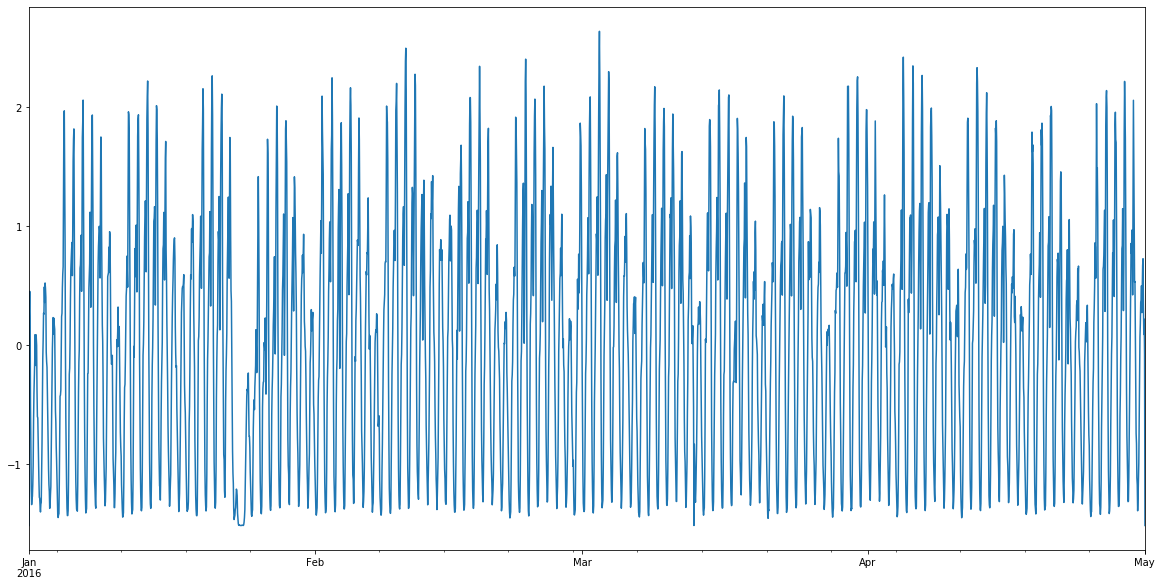

In [108]:
# пример ряда
plt.figure(figsize=(20,10))
(counts_standardized)[np.argmax(means)+1].plot()

# кластеризация

In [109]:
counts_standardized

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018554,...,-0.032147,-0.046981,-0.018554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018554,...,-0.032147,-0.046981,-0.018554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018554,...,-0.032147,-0.046981,-0.018554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018554,...,-0.032147,-0.046981,-0.018554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018554,...,-0.032147,-0.046981,-0.018554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-30 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018554,...,-0.032147,-0.046981,-0.018554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-30 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018554,...,-0.032147,-0.046981,-0.018554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018554,...,-0.032147,-0.046981,-0.018554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018554,...,-0.032147,-0.046981,-0.018554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
